In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
import cv2
import torch
import subprocess
import platform

import numpy as np
import gradio as gr

from basicsr.utils import img2tensor, tensor2img
from torchvision.transforms.functional import normalize

# Custom Modules
import audio
import file_check
import preprocess_mp as pmp
import model_loaders as ml

# Global Variables
TEMP_DIRECTORY = file_check.TEMP_DIR
MEDIA_DIRECTORY = file_check.MEDIA_DIR
NPY_FILES_DIRECTORY = file_check.NPY_FILES_DIR
OUTPUT_DIRECTORY = file_check.OUTPUT_DIR

e:\Lip_Wise_GFPGAN\gan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\Lip_Wise_GFPGAN\gan\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task" to e:\Lip_Wise_GFPGAN\weights\mp\face_landmarker.task



100%|██████████| 3.58M/3.58M [00:00<00:00, 9.08MB/s]


Downloading: "https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite" to e:\Lip_Wise_GFPGAN\weights\mp\blaze_face_short_range.tflite



100%|██████████| 224k/224k [00:00<00:00, 1.50MB/s]


Downloading: "https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth" to e:\Lip_Wise_GFPGAN\weights\gfpgan\GFPGANv1.4.pth



100%|██████████| 332M/332M [00:29<00:00, 11.8MB/s] 


Downloading...
From (uriginal): https://drive.google.com/uc?id=1paYmN1KAZ2oPQPV-XauCoRUorhkOt0s2
From (redirected): https://drive.google.com/uc?id=1paYmN1KAZ2oPQPV-XauCoRUorhkOt0s2&confirm=t&uuid=2207877b-ac96-44d6-a253-82a38505c198
To: e:\Lip_Wise_GFPGAN\weights\wav2lip\wav2lip.pth
100%|██████████| 436M/436M [00:42<00:00, 10.2MB/s] 


Downloading...
From (uriginal): https://drive.google.com/uc?id=1WpqCULKQQcaCNf827h1qgjMHZENYHk-_
From (redirected): https://drive.google.com/uc?id=1WpqCULKQQcaCNf827h1qgjMHZENYHk-_&confirm=t&uuid=3341324c-1549-48f3-a99b-32fb4a0f06a8
To: e:\Lip_Wise_GFPGAN\weights\wav2lip\wav2lip_gan.pth
100%|██████████| 436M/436M [00:41<00:00, 10.6MB/s] 


Using cuda for inference.
Generating audio spectrogram...
Length of mel chunks: 1680
Getting face landmarks...
Extracting face from image...
Warping and aligning face...
Warping and aligning face...
Cropping face...


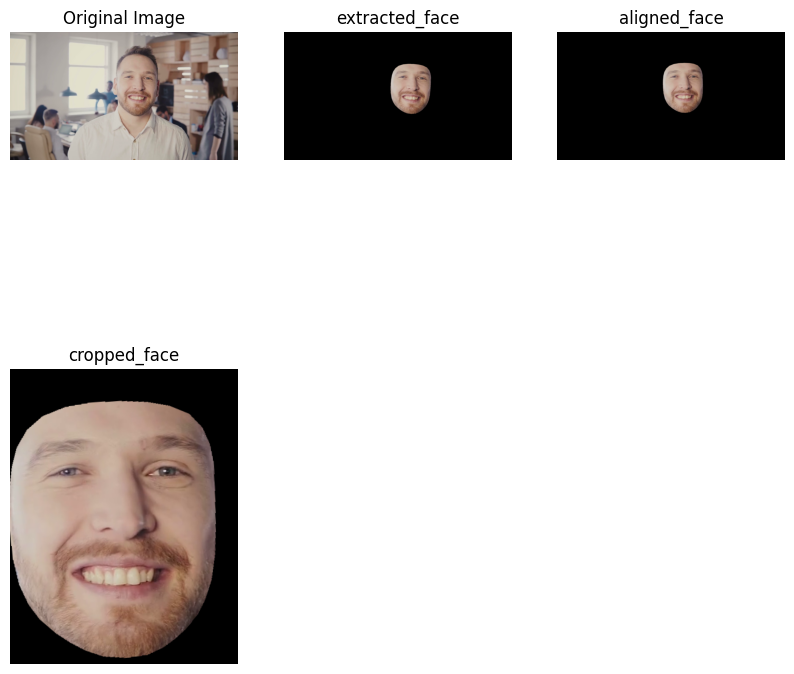

Load checkpoint from: e:\Lip_Wise_GFPGAN\weights\wav2lip\wav2lip.pth


ValueError: too many values to unpack (expected 2)

In [3]:
# Perform checks to ensure that all required files are present
file_check.perform_check()

###################################################################################################################################################

frame_path = r'E:\Lip_Wise_GFPGAN\_testData\Inputs\test1.png'
audio_path = r'E:\Lip_Wise_GFPGAN\_testData\Inputs\test.wav'
mel_step_size = 16
fps = 25

fig = plt.figure(figsize=(10, 10))

###################################################################################################################################################

# Get input type
input_type, img_ext = file_check.get_file_type(frame_path)
if input_type != "image":
    raise Exception("Input file is not an image. Try again with an image file.")

# Get audio type
audio_type, aud_ext = file_check.get_file_type(audio_path)
if audio_type != "audio":
    raise Exception("Input file is not an audio.")
if aud_ext != "wav":
    print("Audio file is not a wav file. Converting to wav...")
    # Convert audio to wav
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(audio_path, os.path.join(MEDIA_DIRECTORY, 'aud_input.wav'))
    subprocess.call(command, shell=True)
    audio_path = os.path.join(MEDIA_DIRECTORY, 'aud_input.wav')

# Check for cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} for inference.')

# Generate audio spectrogram
print("Generating audio spectrogram...")
wav = audio.load_wav(audio_path, 16000)
mel = audio.melspectrogram(wav)

mel_chunks = []
#The mel_idx_multiplier aligns audio chunks with video frames for consistent processing and analysis.
mel_idx_multiplier = 80./fps
i = 0
while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print(f"Length of mel chunks: {len(mel_chunks)}")

# Create media_preprocess object and helper object
processor = pmp.model_processor()

# Read image
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

#######################################################################
a = fig.add_subplot(2, 3, 1)
a.imshow(frame[:, :, ::-1])
a.set_title('Original Image')
a.axis('off')
#######################################################################

# Get face landmarks
print("Getting face landmarks...")
processor.preprocess_image(frame.copy())

# Create face helper object from landmarks
helper = pmp.FaceHelpers(image_mode=True)

# extract face from image
print("Extracting face from image...")
extracted_face, original_mask = helper.extract_face(frame.copy())

#######################################################################
b = fig.add_subplot(2, 3, 2)
b.imshow(extracted_face[:, :, ::-1])
b.set_title('extracted_face')
b.axis('off')
#######################################################################

# warp and align face
print("Warping and aligning face...")
aligned_face, rotation_matrix = helper.warp_align_extracted_face(extracted_face)

#######################################################################
c = fig.add_subplot(2, 3, 3)
c.imshow(aligned_face[:, :, ::-1])
c.set_title('aligned_face')
c.axis('off')
#######################################################################

# Crop face
print("Cropping face...")
cropped_face, bbox = helper.crop_extracted_face(aligned_face, rotation_matrix)

#######################################################################
d = fig.add_subplot(2, 3, 4)
d.imshow(cropped_face[:, :, ::-1])
d.set_title('cropped_face')
d.axis('off')

plt.show()
#######################################################################

# Store cropped face's height and width
cropped_face_height, cropped_face_width, _ = cropped_face.shape

# Generate data for inference
gen = helper.gen_data_image_mode(cropped_face, mel_chunks)

# Load wav2lip model
w2l_model = ml.load_wav2lip_model()

# Load GFPGAN model
gfpgan = ml.load_gfpgan_model()
gfpgan = gfpgan.to(device)

# Initialize video writer
out = cv2.VideoWriter(os.path.join(MEDIA_DIRECTORY, 'temp.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Feed to model:
for i, (img_batch, mel_batch) in enumerate(gr.Progress(track_tqdm=True).tqdm(gen)):
    img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
    mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

    with torch.no_grad():
        dubbed_faces = w2l_model(mel_batch, img_batch)
    
    dubbed_faces = dubbed_faces.cpu().numpy().transpose(0, 2, 3, 1) * 255.

    for d in dubbed_faces:
        d = cv2.resize(d.astype(np.uint8) / 255., (512, 512), interpolation=cv2.INTER_CUBIC)
        dubbed_face_t = img2tensor(d, bgr2rgb=True, float32=True)
        normalize(dubbed_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        dubbed_face_t = dubbed_face_t.unsqueeze(0).to(device)
        
        try:
            output = gfpgan(dubbed_face_t, return_rgb=False, weight=0.5)[0]
            restored_face = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
        except RuntimeError as error:
            print(f'\tFailed inference for GFPGAN: {error}.')
            restored_face = d
        
        restored_face = restored_face.astype(np.uint8)

        # Warp face back to original pose
        
        processed_face = cv2.resize(restored_face, (cropped_face_width, cropped_face_height), interpolation=cv2.INTER_LANCZOS4)
        processed_ready = helper.paste_back_black_bg(processed_face, bbox, extracted_face)
        ready_to_paste = helper.unwarp_align(processed_ready, rotation_matrix)
        restored_image = helper.paste_back(ready_to_paste, frame, original_mask)

        out.write(restored_image)
    
out.release()

command = f"ffmpeg -y -i {audio_path} -i {os.path.join(MEDIA_DIRECTORY, 'temp.mp4')} -strict -2 -q:v 1 {os.path.join(OUTPUT_DIRECTORY, 'output.mp4')}"
subprocess.call(command, shell=platform.system() != 'Windows')

result_path = os.path.join(OUTPUT_DIRECTORY, 'output.mp4')

In [ ]:
if __name__ == "__main__":
    # Create interface
    inputs = [
        gr.Image(type="filepath", label="Image"),
        gr.Audio(type="filepath", label="Audio"),
        gr.Slider(minimum=1, maximum=60, step=1, value=30, label="FPS"),
        gr.Slider(minimum=0, maximum=160, step=16, value=16, label="Mel Step Size")
    ]
    outputs = gr.Video(sources='upload', label="Output")
    title = "Lip Wise"

    gr.Interface(fn=infer_image, inputs=inputs, outputs=outputs, title=title).launch()